# Introducción al manejo de datos geográficos

## Clase 3: Utilización de fuentes secundarias 

En el transcurso de las clases anteriores, introducimos algunos conceptos generales sobre el manejo de datos geográficos. Trabajamos con `geopandas`, vimos lo que era un crs, geolocalizamos datos y exploramos diferentes herramientas de visualización. Ahora, nos vamos a enfocar en una forma diferente de caracterizar y entender nuestros datos: la consulta de fuentes secundarias. Este recurso es de gran utilidad, sobre todo, cuando queremos construir una descripción generalizada del entorno en el que se emplaza el fenómeno que estamos estudiando. En otras palabras, contextualizar nuestro objeto de análisis.

Por ejemplo, si hubiesemos querido reconstruir el contexto edilicio de los frentes registrados en las partidas de conservación patrimonial (el dataset que trabajamos la clase anterior) deberíamos tener en claro cuáles son las fuentes que tenemos disponibles, su caracter o nivel de confiabilidad, con qué periodicidad se publcian y, principalmente, cuál es el nivel administrativo mínimo al que abren su información. Esto último resulta de gran importancia a la hora de definir si un dato se encuentra disponible o no. 

En segunda instancia, profundizaremos en algunas nociones más generales que nos permitirán entender cuándo el manejo de un lenguaje de programación se vuelve una herramienta tan potente y útil para trabajar conceptos propios de las ciencias sociales. Específicamente, veremos cómo se construyen los esquemas de clasificación que se implementan en el método `plot` de un GeoDataFrame. Comprender esto, se vuelve de gran importancia para entender qué es lo que se busca comunicar a la hora de armar mapas coropléticos (o [coropletas](https://es.wikipedia.org/wiki/Mapa_coropl%C3%A9tico)). Asimismo, veremos cómo la construcción de nuestras propias clases puede convertirse en un recurso altamente funcional para la descripción 'a medida' de nuestro fenómeno u objeto. En nuestro caso, el territorio en el que se ubican las fachadas de edificios con certificados de conservación patrimonial.

### Provincias, departamentos, fracciones y radios: el Censo Nacional de Población, Hogares y Viviendas.

![DIVISIONES](imagenes/divisiones_admin.jpeg)

A modo de caso testigo, para el desarrollo del siguiente notebook seleccionaremos una de las fuentes de datos sociodemográficos más consultadas. Trabajaremos con datos del último [Censo](https://www.indec.gob.ar/indec/web/Nivel3-Tema-2-41) que realiza el Instituto Nacional de Estadísticas y Censos - INDEC. Este operativo suele repetirse aproximadamente cada diez años, por lo que los últimos resultados que se encuentran disponibles son los de 1991, 2001 y [2010](https://www.indec.gob.ar/indec/web/Nivel3-Tema-2-41). Como comentario breve, aclaramos que sólo los últimos dos cuentan con sus bases publicadas a nivel usuario. Ambos cuentan con el cuestionario básico accesible a nivel provincial, departamental, fracción y radio censal. 

Vale aclarar que estas no son las únicas, pero sí las [unidades geoestadísticas](https://geoservicios.indec.gov.ar/codgeo/index.php?pagina=definiciones) más comunes a la hora de trabajar el territorio nacional. Por estas, se entiende a:
<br />
...*cada una de las porciones de territorio que se utilizan para referir información estadística. Bajo esta denominación se contemplan tanto las divisiones políticas (por ej. provincias, departamentos, gobiernos locales) como aquellas unidades generadas por el Instituto a fines operativos (por ej. localidad censal, fracción censal, radio censal).*

Estas nos servirán como base cuando tengamos que definir qué nivel de granularidad le damos a nuestro análisis.

In [1]:
# importamos las librerías con las que vamos a trabajar
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

In [2]:
# Cargamos nuestro gdf de radios censales. Al igual que la clase anterior, esto lo descargamos de Buenos Aires Data.
radios = gpd.read_file('carto/informacion_censal_por_radio_2010.shp')

In [3]:
radios.head()

,RADIO_I,BARRIO,COMUNA,POBLACI,VIVIEND,HOGARES,HOGARES_,AREA_KM,geometry
0,1_1_1,RETIRO,1,336.0,82.0,65.0,19.0,1.798997,"POLYGON ((-58.37189 -34.59199, -58.37202 -34.5..."
1,1_12_1,SAN NICOLAS,1,341.0,365.0,116.0,25.0,0.018565,"POLYGON ((-58.38593 -34.60444, -58.38575 -34.6..."
2,1_12_10,SAN NICOLAS,1,296.0,629.0,101.0,1.0,0.044380,"POLYGON ((-58.37879 -34.60528, -58.37741 -34.6..."
3,1_12_11,SAN NICOLAS,1,528.0,375.0,136.0,7.0,0.366340,"POLYGON ((-58.36733 -34.60562, -58.36713 -34.6..."
4,1_12_2,SAN NICOLAS,1,229.0,445.0,129.0,16.0,0.018363,"POLYGON ((-58.38454 -34.60436, -58.38311 -34.6..."


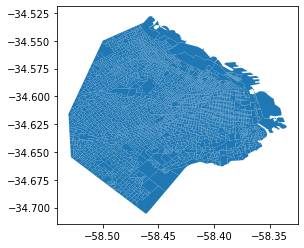

In [4]:
# los radios censales de la Ciudad de Buenos Aires...
radios.plot();

In [5]:
radios.geometry[0].centroid.y

-34.58712584809595

## Parte 1
### Reconstruyendo el contexto edilicio de la ciudad...

#### INMAT: Calidad de los materiales de la vivienda

El Censo proporciona una serie de variables que permiten dar cuenta de los distintos aspectos que hacen a las condiciones de vida de la población. Con estas, el Indec suele realizar sus propios indicadores sintéticos. Muy útiles para construir una primera descripción de la porción de la realidad que estamos analizando. Estos indicadores se presentan bajo la forma de variables categóricas, que asumen valores en función de la conjunción de distintos atributos. Por ejemplo, las cantidad de personas por cuarto o los materiales constructivos de la vivienda. Entre otros, estos sirven para definir la cantidad de hogares con necesidades básicas insatisfechas dentro de una unidad geoestadística.

Dentro de estas dimensiones de análisis, la vivienda cuenta con su propio universo de variables. De una forma más integral, el censo permite hablar sobre el hábitat de las personas a partir del nivel de acceso a distintos servicios urbanos, como son el agua potable o fuentes de energía como el gas y la electricidad.

Por eso, para describir el contexto edilicio que nos hemos propuesto, vamos a apoyarnos en un indicador que describe la tipología de las viviendas. A partir de la calidad de los materiales predominantes en techos y pisos, este indicador proporciona un primer diagnóstico sobre el estado de situación de una vivienda. lo que para nuestra caso, puede resultar útil para verificar el estado de conservación de un inmueble. Esto es, identificar zonas de alta aglomeración de un patrón común y ver si esto se condice con la distribución espacial de nuestras fachadas patrimoniales.  

Este indicador se denomina [INMAT](https://redatam.indec.gob.ar/redarg/CENSOS/CPV2010rad/Docs/base.pdf) y clasifica a las viviendas dentro de una unidad geoestadística en función de las preguntas sobre piso, techo y cielorraso de la cédula censal:

* Calidad I: la vivienda presenta materiales resistentes y sólidos tanto en el piso como en techo;
presenta cielorraso.
* Calidad II: la vivienda presenta materiales resistentes y sólidos tanto en el piso como en el techo.
Y techos sin cielorraso o bien materiales de menor calidad en pisos.
* Calidad III: la vivienda presenta materiales poco resistentes y sólidos en techo y en pisos.
* Calidad IV: la vivienda presenta materiales de baja calidad en pisos y techos.

Veamos cómo podemos agregar esta información a nuestra base de radios censales. Para esto, ya nos tomamos el trabajo de descargar el dataframe de radios censales correspondientes a la ciudad de Buenos Aires con la cantidad de viviendas por tipo de calidad para cada radio censal. Para hacerlo, sólo tienen que ir al `Web Redatam` que hipervinculamos al último censo y elegir la variable deseada en los conteos por área. 

In [6]:
# Vamos a levantar el df 
inmat = pd.read_csv('data/inmat_caba_2010.csv')

In [7]:
# Se puede ver que los códigos de indentificación de radio no coinciden..
inmat.head()

,Código,Calidad 1,Calidad 2,Calidad 3,Calidad 4
0,20010101,19,14,3,2
1,20010201,13,42,59,20
2,20010202,19,39,51,5
3,20010203,8,26,63,1
4,20010204,13,32,59,6


In [8]:
radios.head()

,RADIO_I,BARRIO,COMUNA,POBLACI,VIVIEND,HOGARES,HOGARES_,AREA_KM,geometry
0,1_1_1,RETIRO,1,336.0,82.0,65.0,19.0,1.798997,"POLYGON ((-58.37189 -34.59199, -58.37202 -34.5..."
1,1_12_1,SAN NICOLAS,1,341.0,365.0,116.0,25.0,0.018565,"POLYGON ((-58.38593 -34.60444, -58.38575 -34.6..."
2,1_12_10,SAN NICOLAS,1,296.0,629.0,101.0,1.0,0.044380,"POLYGON ((-58.37879 -34.60528, -58.37741 -34.6..."
3,1_12_11,SAN NICOLAS,1,528.0,375.0,136.0,7.0,0.366340,"POLYGON ((-58.36733 -34.60562, -58.36713 -34.6..."
4,1_12_2,SAN NICOLAS,1,229.0,445.0,129.0,16.0,0.018363,"POLYGON ((-58.38454 -34.60436, -58.38311 -34.6..."


Como el `gdf` lo descargamos desde el portal de datos de la Ciudad, y el Censo es un operativo nacional, es probable que nos encontremos con estos problemas. Basicamente, tener dos formas de representar lo mismo. Muchas veces, esto puede demorarnos el trabajo. Pero, indudablemente, es una tarea que debemos completar para seguir adelante. 

Estas codificaciones responden a una estructura, que es la que desarrolla el INDEC para trabajar con las distintas unidades geoestadísticas. En el caso de la Ciudad, el `02` es el id con el que se identifica la jurisdicción. Después, no debemos olvidar que esta es autónoma y cuenta con una división administrativa propia. No cuenta con departamentos, sino con comunas - las que van de 1 a 15. No perdamos de vista esto ya que el id concatenado con el que estamos trabajando nuestro geodataframe tiene la siguiente:

`CO_FRACC_RA: Concatenado Nº Comuna + Nº Fracción + Nº Radio`

Este es el [formato](https://www.estadisticaciudad.gob.ar/eyc/?p=40970) con el que la Ciudad publica su cartografía censal. Como pueden apreciar, los ids no son distintos en su estructura. El orden de las unidades geoestadísticas siempre es el mismo. Pero sí en su forma. Cuenta con `_` para separar las unidades, y tampoco tiene `0` delante de los valores enteros. A su vez, tampoco lleva el código de la ciudad al inicio (algo que podría haber sido lógico dado que el territorio es el mismo - esto, sin dejar de lado el trabajo que nos suma y que podría haber sido evitado.

Básicamente, lo que haremos es respetar el mismo orden e ir reemplazando separadores mientras eliminamos los caracteres no deseados. Comencemos.

In [9]:
# Armamos una función para adaptar los ids
def reformatea_radio(string):
    '''
    Convierte el formato del id del radio censal
    para la Ciudad de Buenos Aires.
    ...
    Argumentos:
     string(str): id del radio.
     
    Devuelve:
      string : id con nuevo formato  
    '''
    
    acortado = string[2:]
    tuplas = list(zip(acortado[0::2], acortado[1::2]))
    
    arma_id = []
    
    for idx in range(len(tuplas)):
        if tuplas[idx][0]=='0':
            partes = '_'
        elif tuplas[idx][0]!='0':
            partes = '_'+tuplas[idx][0]

        codigo = partes+tuplas[idx][1] 
        arma_id.append(codigo)
        
    radio = ''
    
    for i in arma_id:
        radio = radio + i
        
    id_radio = radio[0].replace('_','')+radio[1:]
    
    return id_radio

In [10]:
# mapeamos la función
inmat['union'] = inmat.Código.astype(str).map(reformatea_radio)

In [11]:
# y de esta manera agregamos el código con un nuevo formato que nos va a permitir unir el gdf.
inmat.head()

,Código,Calidad 1,Calidad 2,Calidad 3,Calidad 4,union
0,20010101,19,14,3,2,1_1_1
1,20010201,13,42,59,20,1_2_1
2,20010202,19,39,51,5,1_2_2
3,20010203,8,26,63,1,1_2_3
4,20010204,13,32,59,6,1_2_4


Antes de continuar, me gustaría aclarar que existen distints formas de agrupar las categorías constructivas que devuelve el `INMAT`. [Agunos](https://atlasid.planificacion.gob.ar/indicador.aspx?id=68) eligen agrupar las calidades 3 y 4 como las dos más bajas. [Otros](http://wadmin.uca.edu.ar/public/ckeditor/2017-Observatorio-Informes_Defensoria-CABA-24-10-VF.pdf), suelen separar a la primera del resto, y tomar este último como el de peor calidad. Este [documento oficial](https://www.indec.gob.ar/ftp/cuadros/sociedad/PDLP_10_14.pdf) define tres tipologías constructivas:

* aceptables
* recuperables
* irrecuperables

*Las primeras son:*

(...) aquellas que por la calidad de los materiales, no necesitan reparación o modificación para satisfacer las necesidades del hogar, ya que poseen materiales resistentes en todos sus componentes y tienen elementos de aislación y terminación. Son las viviendas que cuentan con piso de cerámica, baldosa, mosaico, mármol, madera o alfombra. Los techos son de cubierta asfáltica o membrana, baldosa o losa, pizarra o teja y chapa de metal. Todos los techos cuentan con revestimiento interior (cielorraso). 

*Las segundas son las viviendas recuperables:*
(...) aquellas que requieren reparación o modificación para que puedan cumplir con las condiciones adecuadas. Presentan pisos incompletos, sin terminación y techos sin aislación y terminación, o realizados con materiales de baja resistencia. Son las viviendas que cuentan con piso de cemento o ladrillo fijo y otros. El techo presenta cubierta asfáltica o membrana, baldosa o losa, pizarra o teja, chapa de metal o fibrocemento o plástico y otros. Los techos no cuentan con revestimiento interior. 

*Por último, las viviendas*:

(...) consideradas irrecuperables presentan condiciones precarias. No se pueden mejorar ya que suponen, necesariamente, el reemplazo de sus materiales, debido a que no son resistentes en alguno de sus componentes. Son las viviendas que cuentan con piso de tierra o ladrillo suelto y el techo es de chapa de cartón, caña, tabla o paja con barro o paja sola.

En función de estas definiciones, y considerando que lo que nosotros queremos identificar son entornos más bien tugurizados, vamos a optar por la última opción. Es decir, separaremos la calidad más alta del resto y agruparemos el resto en dos categorías nuevas, asumiendo que en estas zonas (las de menor calidad constructiva) hay una menor concentración de fachadas patrimoniadas. No porque no existan, sino porque responden a situaciones de menor consolidación urbana. Es decir, contextos en los que impera una fuerte tensión entre tejidos residenciales e industriales, con espacios abiertos sin usos claros delimitados, o galpones y playas con poco uso, etc etc.

In [12]:
inmat['aceptables'] = inmat['Calidad 1'].copy() 
inmat['recuperables'] = inmat['Calidad 2']
inmat['irrecuperables']= inmat['Calidad 3']+inmat['Calidad 4'] 

In [13]:
inmat.head()

,Código,Calidad 1,Calidad 2,Calidad 3,Calidad 4,union,aceptables,recuperables,irrecuperables
0,20010101,19,14,3,2,1_1_1,19,14,5
1,20010201,13,42,59,20,1_2_1,13,42,79
2,20010202,19,39,51,5,1_2_2,19,39,56
3,20010203,8,26,63,1,1_2_3,8,26,64
4,20010204,13,32,59,6,1_2_4,13,32,65


In [14]:
# mergeamos con nuestro gdf
radios_inmat  = pd.merge(radios, inmat, left_on='RADIO_I', right_on='union')

In [15]:
# ... y obtenemos nuestro geodataframe con todos los valores deseados.
radios_inmat.head()

,RADIO_I,BARRIO,COMUNA,POBLACI,VIVIEND,HOGARES,HOGARES_,AREA_KM,geometry,Código,Calidad 1,Calidad 2,Calidad 3,Calidad 4,union,aceptables,recuperables,irrecuperables
0,1_1_1,RETIRO,1,336.0,82.0,65.0,19.0,1.798997,"POLYGON ((-58.37189 -34.59199, -58.37202 -34.5...",20010101,19,14,3,2,1_1_1,19,14,5
1,1_12_1,SAN NICOLAS,1,341.0,365.0,116.0,25.0,0.018565,"POLYGON ((-58.38593 -34.60444, -58.38575 -34.6...",20011201,102,12,0,0,1_12_1,102,12,0
2,1_12_10,SAN NICOLAS,1,296.0,629.0,101.0,1.0,0.044380,"POLYGON ((-58.37879 -34.60528, -58.37741 -34.6...",20011210,82,14,1,0,1_12_10,82,14,1
3,1_12_11,SAN NICOLAS,1,528.0,375.0,136.0,7.0,0.366340,"POLYGON ((-58.36733 -34.60562, -58.36713 -34.6...",20011211,103,24,0,5,1_12_11,103,24,5
4,1_12_2,SAN NICOLAS,1,229.0,445.0,129.0,16.0,0.018363,"POLYGON ((-58.38454 -34.60436, -58.38311 -34.6...",20011202,107,22,0,0,1_12_2,107,22,0


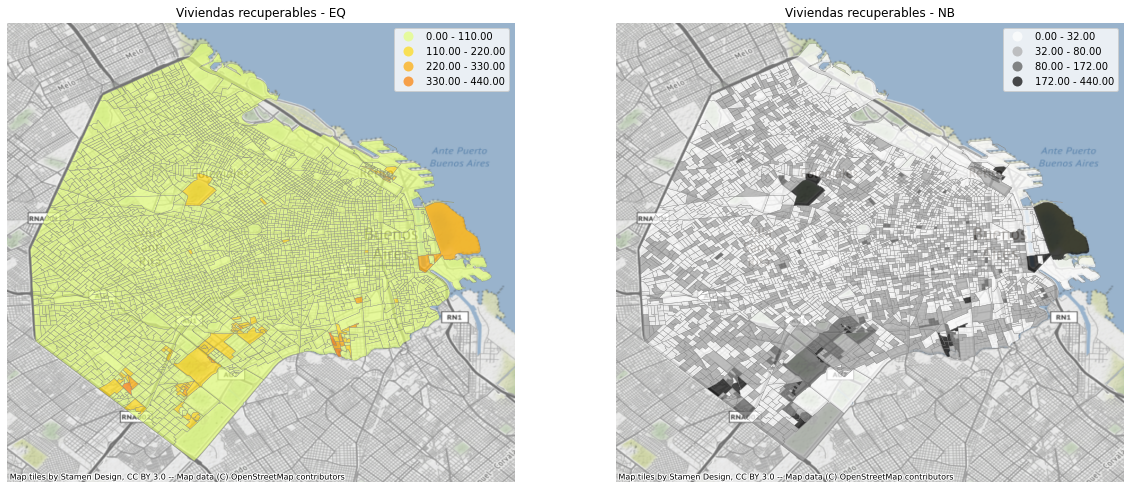

In [16]:
# veamos ahora cómo se intepretan nuestros datos...
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

eq = radios_inmat.plot(ax=ax1, column='recuperables',
                        cmap = 'Wistia', scheme='equalinterval', k=4, 
                        edgecolor = 'grey', linewidth = 0.4, alpha= 0.7, legend=True)

ctx.add_basemap(eq,zoom=12, crs=4326)
ax1.set_title('Viviendas recuperables - EQ')
ax1.set_axis_off()

nb = radios_inmat.plot(ax=ax2, column='recuperables', 
                        cmap = 'gist_yarg', scheme='naturalbreaks', k=4, 
                        edgecolor = 'grey', linewidth = 0.4, alpha= 0.7, legend=True)

ctx.add_basemap(nb,zoom=12, crs=4326)
ax2.set_title('Viviendas recuperables - NB')

ax2.set_axis_off();

Hagamos una primera pausa. Recuerdan que dijimos que a la hora de armar una coropleta era importante saber qué es lo que queríamos comunicar? Bueno, para eso debemos conocer cómo trabajan los esquemas de clasificación de `mapclassify`. A la izquerda, definimos intervalos iguales. es decir, cuántos casos caen en cada intervalo definido dentro de un mismo rango o distancia (en nuestro ejemplo, 110 viviendas). 

Si prestamos atención, generalmente las zonas más intensas son las que corresponden a polígonos de mayor tamaño (en algunos casos con presencia de asentamientos informales, en otros grandes macizos cercanos al ferrocarril). Y siempre con alta concentración en el sur de la ciudad. 

Por su parte, el mapa de la derecha no hace más que confirmar este patrón, aunque extendiéndose sobre el resto de la ciudad sin un parámertro o patrón definido.

Veamos por qué se producen estas diferencias a la hora de clasificar valores dentro de un array de una dimensión. Para eso, empecemos por revisar la distribución de nuestros valores... 

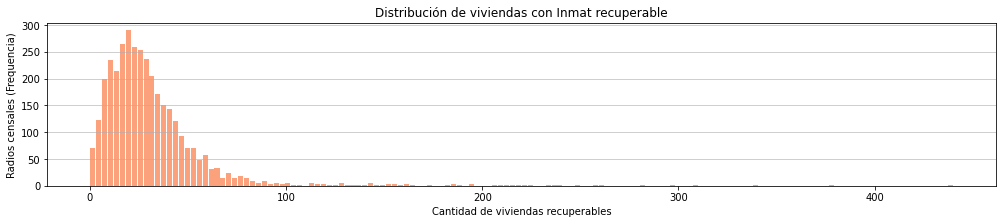

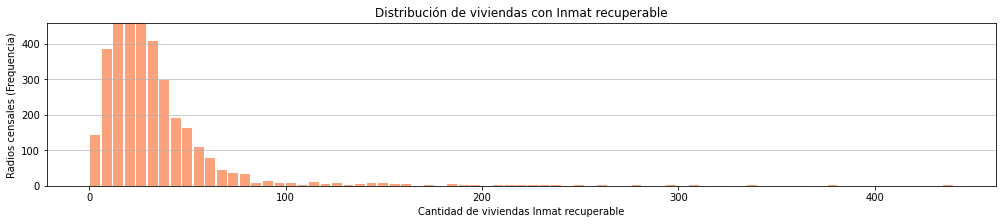

In [17]:
fig = plt.figure(figsize = (17,3))
plt.hist(x=radios_inmat['recuperables'].values, bins= 'auto', color='#FA7A44',
                            alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Cantidad de viviendas recuperables')
plt.ylabel('Radios censales (Frequencia)')
plt.title('Distribución de viviendas con Inmat recuperable')

fig = plt.figure(figsize = (17,3))
plt.hist(x=radios_inmat['recuperables'].values, bins=75, color='#FA7A44',
                            alpha=0.7, rwidth=0.85)


plt.grid(axis='y', alpha=0.75)
plt.xlabel('Cantidad de viviendas Inmat recuperable')
plt.ylabel('Radios censales (Frequencia)')
plt.title('Distribución de viviendas con Inmat recuperable')
maxfreq = radios_inmat['recuperables'].values.max() + 10

# seteamos el límite superior del eje y. Si al dividirlo por 10 tenemos resto se lo redondea
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10);

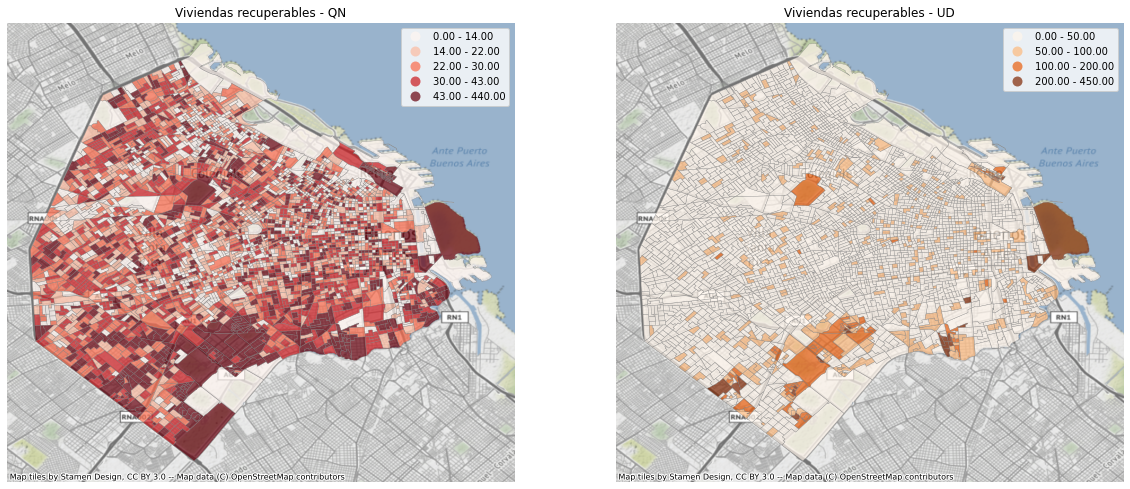

In [18]:
# Y ploteamos nuevamente utilizando cuantiles y bins definidos manualmente
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

qn = radios_inmat.plot(ax=ax1, column='recuperables',
                        cmap = 'Reds', scheme='Quantiles', k=5, 
                        edgecolor = 'grey', linewidth = 0.4, alpha= 0.7, legend=True)

ctx.add_basemap(qn,zoom=12, crs=4326)
ax1.set_title('Viviendas recuperables - QN')
ax1.set_axis_off()

# se puede ver que los cortes para los bins los armamos en el diccionario que se pasa como parametro
ud = radios_inmat.plot(ax=ax2, column='recuperables', 
                        cmap = 'Oranges', scheme='UserDefined', classification_kwds={'bins':[50, 100, 200, maxfreq]}, 
                        edgecolor = 'grey', linewidth = 0.4, alpha= 0.7, legend=True)

ctx.add_basemap(ud,zoom=12, crs=4326)
ax2.set_title('Viviendas recuperables - UD')
ax2.set_axis_off();

Podemos seguir confirmando el mismo patrón que visualizamos inicialmente. La distribución por quantiles, nos permite ver que el 20% más alto de nuestro universo sigue concentrandose en el sur de la ciudad. Esto también se puede confirmar si revisamos dónde se concentran los valores más altos en el mapa que construimos a partir de los bins definidos manualmente.

### Estrategias de clasficiación: mapclassify 

Veamos un poco más en detalle lo que estuvimos haciendo con estas coropletas. El método plot de `geopandas` utiliza `mapclassify`, una librería de `pysal` para construir esquemas de clasificación de acuerdo a la distribución de nuestros datos. 

Para ello, brinda distintos mecanismos. Algunos se encuentran explicados en su [repositorio](https://github.com/pysal/mapclassify). Otros se puede encontrar [en esta publicación](https://geographicdata.science/book/notebooks/05_choropleth.html#Choropleth-mapping) sobre usos de esquemas de clasificación cuantitativa en mapas de coropletas. 

`Mapclassify` cuenta con varias estrategias de clasificación. Acá no vamos a repasar todas, pero sí vamos a tratar de tener un pantallazo general para conocer cómo funcionan algunas de ellas. Al menos las más populares o más utilizadas para la visualización de coropletas.

In [19]:
# Importamos la librería
import mapclassify

Primero evaluemos cómo es la distribución de los valores del array que estamos ploteando en el mapa.

In [20]:
radios_inmat['recuperables'].describe()

count    3553.000000
mean       32.050661
std        29.753609
min         0.000000
25%        16.000000
50%        26.000000
75%        39.000000
max       440.000000
Name: recuperables, dtype: float64

Tenemos un total de 3553 radios censales, siendo 16 y 39 la cantidad de viviendas recuperables que nos marcan la división entre el 25% más bajo y el 75% más alto. El radio con mayor cantidad de casos alcanza 440 viviendas con calidad constructiva recuperable. 

> **1. Percentiles**

La primera clase que vamos a revisar son los percentiles. Acorde a la descripción previa, podemos constatar que en percentil 25 caen 925 radios censales. Es decir, si decidiéramos quedarnos con el 25% más bajo de nuestra distribución el punto de corte debería fijarse en un máximo de 16 viviendas recuperables. Lo que nos permite ver esto es que la distancia entre el techo del percentil 75 y el máximo valor de la distribución tiene un rango bastante alto. Entre los percentiles 75 y 100, la cantidad de viviendas recuperables puede ir de 39 a 440 (lo que muestra una dispersión bastante alta)

In [21]:
percentiles = mapclassify.Percentiles(radios_inmat['recuperables'].values, pct=[25, 50, 75, 100])

In [22]:
percentiles

Percentiles             

    Interval       Count
------------------------
[  0.00,  16.00] |   925
( 16.00,  26.00] |   903
( 26.00,  39.00] |   841
( 39.00, 440.00] |   884

> **2. Quantiles**

Como avanzamos en la clase anterior, los quantiles dividen nuestros casos en cinco grupos iguales. Del 20% más bajo al más alto. Bastante similar a lo que vimos con los percentiles. De esta forma, el primer intervalo (o quintil) nos dirá la cantidad de radios censales con una cantidad inferior a las 14 viviendas (el punto de corte que se establece para delimitar el primer 20% de nuestros casos). La misma lógica, de manera incremental, aplica al resto de los intervalos.

In [23]:
quantiles = mapclassify.Quantiles(radios_inmat['recuperables'].values, k=5)

In [24]:
quantiles

Quantiles               

    Interval       Count
------------------------
[  0.00,  14.00] |   781
( 14.00,  22.00] |   716
( 22.00,  30.00] |   646
( 30.00,  43.00] |   709
( 43.00, 440.00] |   701

> **3. Equal interval**

También podemos definir intervalos de antemano. Esto suele ser bastante útil para contrastar con esquemas que plotean en base a la distribución natural de nuestros datos. 

In [25]:
e_interval = mapclassify.EqualInterval(radios_inmat['recuperables'].values, k=5)

In [26]:
e_interval

EqualInterval           

    Interval       Count
------------------------
[  0.00,  88.00] |  3444
( 88.00, 176.00] |    80
(176.00, 264.00] |    23
(264.00, 352.00] |     4
(352.00, 440.00] |     2

> **4. User defined**

Mapclassify también nos da la posibilidad de prefijar los límites de nuestros bins. Por ejemplo, vimos que la mayor cantidad de viviendas recuperables se encuentran en intervalos con valores bajos. Este esquema es útil si quisiéramos enfocarnos, por ejemplo, en el universo que está por debajo del percentil 75.

In [27]:
ud = mapclassify.UserDefined(radios_inmat['recuperables'].values, bins=[5, 10, 15, 20, 25, 30, 35, 40, maxfreq])
ud

UserDefined             

    Interval       Count
------------------------
[  0.00,   5.00] |   142
(  5.00,  10.00] |   309
( 10.00,  15.00] |   389
( 15.00,  20.00] |   467
( 20.00,  25.00] |   430
( 25.00,  30.00] |   406
( 30.00,  35.00] |   331
( 35.00,  40.00] |   254
( 40.00, 450.00] |   825

In [28]:
# algo que no mencionamos es que uno de los atributos de estas clases son los bins. 
ud.bins

array([  5,  10,  15,  20,  25,  30,  35,  40, 450])

> **5. En base a medias**

`Mapclassify` también cuenta con algunos métodos de clasificación que operan a partir de la media como estadístico resúmen principal. Dos de los más conocidas en el mundo de los sistemas de información geográfica son los cortes naturales o `natural breaks` y los `fisher jenks`. Ambos trabajan con medias sobre un array de una dimensión, con la principal diferencia que el primero lo hace a partir de [la implementación de k-means de scikit learn](https://github.com/pysal/mapclassify/blob/master/mapclassify/classifiers.py#L8). Mientras el otro es una optimización que busca aumentar la homogeneidad al interior de una clase y la heterogeneidad de cada una respecto de las demás. Esto, a partir del uso exclusivo de `numpy` y de recursos nativos de python.

Comparemoslos y veamos, un poco más a bajo nivel, cómo es que ambos trabajan... 

>> **5.1. Fisher Jenks**

In [29]:
import time

In [30]:
# Instanciemos nuestro clasificador. Aprovechemos también para ver cuánto tarda...
inicio_fj = time.time()
fj = mapclassify.FisherJenks(radios_inmat['recuperables'].values, k=4)
fin_fj = time.time()

In [31]:
fj

FisherJenks             

    Interval       Count
------------------------
[  0.00,  32.00] |  2277
( 32.00,  85.00] |  1158
( 85.00, 187.00] |    94
(187.00, 440.00] |    24

In [32]:
# Tardamos ...
fin_fj - inicio_fj

36.63364100456238

In [33]:
# en encontrar 4 cortes para un array de... 
len(radios_inmat['recuperables'])

3553

Por el momento, no vamos a definir si esto es poco o mucho. Sólo tengamos en mente la performance de este método para compararlo más adelante.

#### Vamos por partes, breve digresión sobre el funcionamiento del clasificador: 

Como ya lo mencionamos, los `Fisher Jenks` clasifican valores dentro de un array a partir de la media. Pero a partir de qué media? La media del array o las medias de las clases que quedan conformadas a partrit del parámetro `k`? A continuación vamos a ver cómo es que este método clasifica un número predefinido de clases a partir del uso de la media. Para eso, pongamos un ejemplo sencillo:

In [34]:
# Instanciamos nuestro array
array = [10,14,30,31,32]

Acá los valores de corte se definen, a partir de un array ordenado, buscando el id de aquel que minimice la suma de las desviaciones absolutas al interior de cada clase. Con esto, ya damos una primera respuesta. La clasificación trabaja inicialmente a partir de la media de las clases que se van conformando. En la [implementación](https://github.com/pysal/mapclassify/blob/master/mapclassify/classifiers.py#L508-L562) de `mapclassify`, los puntos de corte se construyen tomando como punto de partida cada valor del array e iterando hacia atrás sobre el resto. Así, se iran sumando gradualmente las desviaciones y el valor que minimice esa suma es el que se toma como punto corte. Para nuestro ejemplo, el orden de iteración sería el siguiente:
```
14: [14,10]
30: [30,14,10]
31: [31,30,14,10]
32: [32,31,30,14,10]
```
... y a [medida que se vaya agregando cada valor se irán sumando las desviaciones respecto de la media de esa combinación](https://github.com/pysal/mapclassify/blob/master/mapclassify/classifiers.py#L539-L542) que queda conformada. El valor de la iteración que minimice esta distancia, es el que se usará como punto de corte. En nuestro ejemplo, si hubieran dos clases (`k`), nuestro array quedaría ordenado  a partir de los valores que se ubican por debajo del `14` y, por encima de este y debajo del `32`. 

Como dijimos, lo que hace el enfoque programático de este método es [iterar de atrás hacia adelante](https://github.com/pysal/mapclassify/blob/master/mapclassify/classifiers.py#L532) por todos los items de nuestra lista de valores...

In [35]:
# se puede ver que a partir de cada llave, la iteración es hacia atrás...
for l in range(2, len(array) + 1):
    combinacion = []
    for m in range(1, l + 1):
        v = array[(l - m + 1)-1]
        combinacion.append(v)
        print('combinacion:{}'.format(combinacion))

combinacion:[14]
combinacion:[14, 10]
combinacion:[30]
combinacion:[30, 14]
combinacion:[30, 14, 10]
combinacion:[31]
combinacion:[31, 30]
combinacion:[31, 30, 14]
combinacion:[31, 30, 14, 10]
combinacion:[32]
combinacion:[32, 31]
combinacion:[32, 31, 30]
combinacion:[32, 31, 30, 14]
combinacion:[32, 31, 30, 14, 10]


... e ir comparando, en cada iteración, la suma de las desviaciones absolutas. Esto es, la sumatoria de la distancia de cada item respecto de la media del array que se va conformando a medida que se agregan nuevos items. Para esta comparación es importante tener en cuenta la cantidad de clases que definimos de antemano, nuestro parámetro `k`. Este es el que define la cantidad de grupos (o combinaciones) que suman estas distancias. De tal manera, para cada combinación se ira comparando contra la sumatoria de otros grupos compuestos por una misma cantidad de clases y revisando, de todas las opciones, cuál es la que minimiza la suma de las distancias a la media.

In [36]:
# Suma de las desviaciones absolutas a la media de la clase
def SADCM(valores):
    '''
    Calcula la suma de las desviaciones a la media de un array
    '''
    s1 = 0
    s2 = 0
    w = 0
    for val in valores:
        s2 += val * val
        s1 += val
        w += np.float32(1)
        v = s2 - (s1 * s1) / w
    return v

Es válido aclarar que, si estamos probando un número de clases `k`, para que le comparación tenga sentido la cantidad de items de nuestro array o lista debe ser mayor. Como estamos trabajando con un `k==2`, comencemos por el tercer valor de nuestra lista:`30`. 

In [37]:
def sadcm_para_comparar(g):
    '''
    Devuelve la sadcm para un grupo de listas.
    ...
    g: lista de listas
    '''
    sadcm = {}
    v = 0
    idx = 0
    for l in g:
        v += SADCM(l) 
        idx += 1
        sadcm[idx] = v
    return v

In [38]:
def compara_sadcm(g1, g2):
    '''
    Compara la sadcm entre dos grupos de n listas
    '''
    
    v1 = sadcm_para_comparar(g1)
    v2 = sadcm_para_comparar(g2)
    
    if v1>= v2:
        print("La combinacion que minimiza SADCM: {}".format(str(g2)))
        return v2
    else:
        print("La combinacion que minimiza SADCM: {}".format(str(g1)))
        return v1

In [39]:
# Vamos con el 30
compara_sadcm([[14,10]], [[14,30]])

La combinacion que minimiza SADCM: [[14, 10]]


8.0

En términos del código, se calcula la SADCM del primer valor de la combinación (`30`) y se lo suma al del último grupo de la combinación anterior (`[14-10]`). Esta lógica se repite, sumando al valor inicial la SADCM del siguiente (en este caso `14`, es decir, `[30-14]`) y volviendo a comparar contra la combinación previa a la de la última clase comparada. Como en este caso esa clase anterior sólo esta conformada por el valor `10`, lo que se termina comparando es lo siguiente: 

* `[14-30][10] VS [30][14-10]` 


In [40]:
compara_sadcm([[14,30],[10]],[[30],[14,10]])

La combinacion que minimiza SADCM: [[30], [14, 10]]


8.0

Lo que tenemos que tener en cuenta acá son los valores que están en el primer corchete del término que ponemos a la derecha del `VS`. En el caso de arriba, el `30`. Por qué? porque si recordamos que la lógica de iteración era `hacia atrás`, veremos que ahí es donde se van a ir agregando las sumas de las desviaciones absolutas de cada clase respecto de su media. Presten atención al `[30]`y repasemos esta lógica de iteración:

1. [14]
   [14, 10]
2. [30]
   [30, 14]
   [30, 14, 10]
3. [31]
   [31, 30]
   [31, 30, 14]
   [31, 30, 14, 10]
4. [32]
   [32, 31]
   [32, 31, 30]
   [32, 31, 30, 14]
   [32, 31, 30, 14, 10]

Si prestamos atención a las combinaciones que se van formando a partir del `[30]`, se ve que para elegir `el valor` que minimiza la suma de las desviaciones absolutas, se va evaluando en cuanto aumenta la distancia a la media a medida que se van agregando cada uno de los items del array. Para las combinaciones que se van formando a partir del `30`, se evaluará primero este número y luego el `14` (`[30-14]`). No contabilizamos el último (`10`) porque cuando se llega al principio del array (`[30-14-10]`) se almacena esa SADCM y se la suma a la del valor siguiente para comenzar a formar las combinaciones correspondientes a esa próxima llave (`31`, es decir, `[31][30-14-10]`). 

Es así que, entre `[30]+[14-10]` y `[30-14]+[10]`, se seleccionará el último valor agregando que minimizó la suma de las desviaciones abslutas. En nuestro ejemplo, el `30`. 

In [41]:
# Esta es la suma de las desviaciones absolutas para la primer combinación de la llave '30'
SADCM([30])+SADCM([14,10])

8.0

In [42]:
# Y esta la que queda conformada cuando se agrega el índice 2 del array inicial. Es decir, '14'
SADCM([30,14])+SADCM([10])

128.0

No lo mencionamos, pero para las combinaciones correspondientes a la primera llave (`[14]`), es aún más sencillo. `[14]+[10]` suman cero y `[14-10]` se almacena para la primera llave posterior (`30`) como lo vimos previamente. Esta operación se ira repitiendo para todas las llaves de las combinaciones y se ira [almacenando en una matriz de dos dimensiones](https://github.com/pysal/mapclassify/blob/master/mapclassify/classifiers.py#L526) el [índice del último item agregado que haya minimizado la suma de las desviaciones absolutas](https://github.com/pysal/mapclassify/blob/master/mapclassify/classifiers.py#L547) a la media de las clases que se fueron conformando en las distintas combinaciones. 

Para el `10`, el último valor agregado que minimizó la SADCM de las combinaciones fue `10`. Lo mismo para `14` y para `30`. Así es que hasta esa llave, se almacenaron los índices `[1,2,3]`. 

Algo más que debemos remarcar es que acá, nuestro parámetro `k` definirá la [cantidad de iteraciones de cada comparación](https://github.com/pysal/mapclassify/blob/master/mapclassify/classifiers.py#L545-L548). Es decir, entre cuantos grupos de valores se evalúa cada combinación. En nuestro ejemplo, al ser un k de dos sólo se compara la suma de las desviaciones de un grupo de dos clases contra las de otro (también de dos clases). Si hubiese sido un k de 3, hubiesemos agregado una tercer clase en la comparación.

**Ahora con 31,**

* `[31-30][14-10] VS [31],[30-14-10]`
* `[10][14,30,31] VS [31-30],[14-10]`

In [43]:
compara_sadcm([[31,30],[14,10]],[[31],[30,14,10]])

La combinacion que minimiza SADCM: [[31, 30], [14, 10]]


8.5

In [44]:
compara_sadcm([[10],[14,30,31]],[[31,30],[14,10]])

La combinacion que minimiza SADCM: [[31, 30], [14, 10]]


8.5

Ahora, vemos que el último valor agregado que minimizó la suma de las desviaciones absolutas a la media de la clase fue el `30`. La combinación conformada por `[[31, 30], [14, 10]]` es la que minimiza la suma de las desviaciones absolutas.

**...y con 32**

* `[31-32][30-14-10] VS [32][31-30-14-10]`
* `[30-31-32][14-10] VS [31-32][30-14-10]`
* `[14-30-31-32][10] VS [30-31-32][14-10]`

In [45]:
# y el 32...
compara_sadcm([[31,32],[30,14,10]],[[32],[31,30,14,10]])

La combinacion que minimiza SADCM: [[31, 32], [30, 14, 10]]


224.5

In [46]:
compara_sadcm([[30,31,32],[14,10]],[[31,32],[30,14,10]])

La combinacion que minimiza SADCM: [[30, 31, 32], [14, 10]]


10.0

In [47]:
compara_sadcm([[14,30,31,32],[10]],[[30,31,32],[14,10]])

La combinacion que minimiza SADCM: [[30, 31, 32], [14, 10]]


10.0

Y con `32` pasa lo mismo que con `31`. El último valor agregado que minimiza la suma de las desvaciones es `30`. 
De esta manera, en la matriz que mencionamos más arriba nos habrá quedado almacenada la siguiente secuencia:

```
 [0 0 0]
 [0 1 1]
 [0 1 2]
 [0 1 3]
 [0 1 3]
 [0 1 3]
```

Qué significa? el vector de unos indica el primer valor de la iteración (de atrás hacia adelante) al que se llegó a partir de cada una de las llaves (14,30,31 y 32). Por ejemplo,`[10]` para la llave 10, `[10-14]` para la llave 14 y así sucesivamente. Es decir, ese vector de unos indica que yendo de atrás para adelante todas las combinaciones llegaron al primer valor del array (10). Paralelamente tenemos un segundo vector a la derecha con valores distintos al uno. Estos representan el índice que ocupaba cada valor de la combinación en el array original. Y por qué se detiene en 1;2 y 3?. Porque los valores correspondientes a ese índice son los que minimizan la suma de las desviaciones para cada combinación. Como para el `[10]` el valor que minimizaba la SADCM era él mismo, se almacena en el vector de la derecha el `idx` `1`. Para las combinaciones que empezaban a partir del 14, como este también era el que minimizaba se almacena el `idx` `2`. Y por último el `idx` `3` para las llaves 30,31 y 32.

Finalmente, [esa matriz se ira utilizando](https://github.com/pysal/mapclassify/blob/master/mapclassify/classifiers.py#L552-L561) conjuntamente con la cantidad de clases definidas como parametro (nuestro `k` inicial) para encontrar el límite superior de cada una de nuestras clases. En nuestro ejemplo, en el que seteamos un `k == 2`, estos límites serán el 14 y el 32. Es decir, una primera clase conformada por `[10-14]` y otra con `[30-31-32]`.


Pero esto no es casual, `30` es la mediana del array original. Si lo que se busca es minimizar la suma de las distancias de cada item a la media del array, esto se consigue a partir de la mediana del mismo. En otras palabras, la suma mínima de las distancias se logra en la mediana del array. Por qué? porque es el punto más cercano entre 10-14 y 31-32. Es decir, es el punto más cercano entre el principio y el final del array, lo que hace que [la suma acumulada de desviaciones o distancias de un extremo al otro se aminoren llegando a ese punto](https://math.stackexchange.com/questions/113270/the-median-minimizes-the-sum-of-absolute-deviations-the-l-1-norm).

#### Y qué fórmula tiene el cálculo de las desviaciones en este método?

La forma en la que se calculan las sumas de las desviaciones a la media de la clase que se utiliza en la [implementación](https://github.com/pysal/mapclassify/blob/master/mapclassify/classifiers.py#L539-L542) de `fisher-jenks` de mapclassify no es más que el conocido (Xi - <span style="text-decoration:overline">X</span>):
![SADCM](imagenes/sadcm.png) 

Es decir, se calcula la desviación de cada i respecto de la media, se suma el próximo valor de la combinación que se forma iterando hacia atrás y se repite la operación. En otras palabras, lo que se hace en mapclassify es lo que se muestra en el último recuadro debajo de la flecha. Acá podés ver la [explicacion completa](https://docs.google.com/document/d/19GVGFe-ERazKPrap-HASJH4QOKnVYns7diFdS9F8t-Q/edit?usp=sharing). Fijémonos una manera alternativa de hacerlo.

Para ello, hagamos una nueva función que calcule la suma de las distancias a la media del array. Tomemos como referencia la fórmula del recuadro anterior a la flecha. Así,

In [48]:
def SADCM_V2(valores):
    '''
    Calcula la suma de las desviaciones 
    a la media del array 
    '''
    media = np.mean(valores)
    sadm = 0
    for x in valores:
        sadm += (x**2)-2*x*media+media**2
        print(str(x)+':'+str(sadm))
    
    return sadm

In [49]:
SADCM_V2(np.array([32,31,30,14,10]))

32:73.96000000000004
31:131.72000000000003
30:175.27999999999997
14:263.64
10:443.19999999999993


443.19999999999993

Lo que nos devuelve esto es cuánto va incrementando la suma de las desviaciones a la media a medida que vamos sumando items al array. Es decir, 

In [50]:
# con 32 es cero
SADCM_V2(np.array([32]))

32:0.0


0.0

In [51]:
# cuando agregamos el 31
SADCM_V2(np.array([32,31]))

32:0.25
31:0.5


0.5

In [52]:
# con el 30
SADCM_V2(np.array([32,31,30]))

32:1.0
31:1.0
30:2.0


2.0

In [53]:
# con el 14
SADCM_V2(np.array([32,31,30,14]))

32:27.5625
31:45.625
30:56.1875
14:218.75


218.75

In [54]:
# y con el 10
SADCM_V2(np.array([32,31,30,14,10]))

32:73.96000000000004
31:131.72000000000003
30:175.27999999999997
14:263.64
10:443.19999999999993


443.19999999999993

Por eso, cuando comparábamos entre:

In [55]:
compara_sadcm([[31,32],[30,14,10]],[[32],[31,30,14,10]])

La combinacion que minimiza SADCM: [[31, 32], [30, 14, 10]]


224.5

In [56]:
compara_sadcm([[30,31,32],[14,10]],[[31,32],[30,14,10]])

La combinacion que minimiza SADCM: [[30, 31, 32], [14, 10]]


10.0

In [57]:
# y ...
compara_sadcm([[14,30,31,32],[10]],[[30,31,32],[14,10]])

La combinacion que minimiza SADCM: [[30, 31, 32], [14, 10]]


10.0

La que minimiza la suma de distancias a la media es la combinación que se conforma entre `[30, 31, 32]` y `[14, 10)]`. Y esto es algo bastante interesante que se puede apreciar en la implementación de mapclassify. Se va calculando la suma de las desviaciones al cuadrado a medida que van entrando nuevos items a la iteración que va conformando cada combinación de valores. Primero se toma el `[32]`, se calcula la desviación a la media (la cual por el momento es cero porque el array tiene sólo un valor) y se le suma las desviacionesa a la media en un array conformado por `[31,30,14,10]`. Esto porque sólo tenemos dos clases (`k=2`). Si hubiésemos tenido un `k=3`, también se hubiese agregado la suma de las desviaciones del array que queda conformado por el id siguiente en orden descendente. Es decir `[30,14,10]`. Pero como trabajamos con un `k=2`, sólo sumamos esos dos grupos y los comparamos con la suma entre`[31,32]` y `[30,14,10]`. Lo que no es más que volver a calcular la suma de las desviaciones a la media entre dos arrays agregando un `31` al `[32]`(y sacandolo del `[31,30,14,10]`). Y como vemos a continuación: 

In [58]:
SADCM_V2(np.array([32,31]))+SADCM_V2(np.array([30,14,10]))

32:0.25
31:0.5
30:144.0
14:160.0
10:224.0


224.5

In [59]:
SADCM_V2(np.array([32]))+SADCM_V2(np.array([31,30,14,10]))

32:0.0
31:95.0625
30:171.625
14:224.1875
10:350.75


350.75

Agregar el `31` al `[32]` y quitarlo de `[31,30,14,10]` hace que lo que se agrega en `[31,32]`y`[30,14,10]` sea la combinación que minimiza la sumatoria de las distancias al cuadrado (como se ve en el paso de 0.25 a 0.5 y de 0 a 95 cuando el `32` está solo). Así, se volverá a agregar el `30` al `32` inicial (que ahora arrastra el `31`) y se hará la misma comparación. Esto nos hace llegar a `[30, 31, 32]` y `[14, 10)]`. 

Y lo mismo con cada uno de los valores del array inicial:

```
((14**2)-((14)**2)/1)
((14**2+10**2)-((14+10)**2)/2)

((30**2)-((30)**2)/1)
((30**2+14**2)-((30+14)**2)/2)
((30**2+14**2+10**2)-((30+14+10)**2)/3)

((31**2)-((31)**2)/1)
((31**2+30**2)-((31+30)**2)/2)
((31**2+30**2+14**2)-((31+30+14)**2)/3)
((31**2+30**2+14**2+10**2)-((31+30+14+10)**2)/4)

((32**2)-((32)**2)/1)
((32**2+31**2)-((32+31)**2)/2)
((32**2+31**2+30**2)-((32+31+30)**2)/3)
((32**2+31**2+30**2+14**2)-((32+31+30+14)**2)/4)
((32**2+31**2+30**2+14**2+10**2)-((32+31+30+14+10)**2)/5)
```

Lo que programáticamente se resuelve muy eficientemente en `mapclassify` optimizando la selección automática de los valores que minimizan la suma de los cuadrados. En otras palabras, lo que se muestra a continuación, se encuentra inserto, en mapclassify, en un flujo de trabajo en el que todas las combinaciones de valores se hace automáticamente en función de los valores del array y del parámetro `k`.

In [60]:
# Armamos una función para devolver la suma de las desviaciones al cuadrado a la media de la clase
def sd_entre_clases(valores, idx):
    '''
    Calcula la suma de las desviaciones 
    a la media de la clase para un k=2.
    '''
    s1 = valores[:idx]
    s2 = valores[idx:]
    print(s1)
    print(s2)
    print('****************')
    
    mean1=np.array(s1).mean()
    mean2=np.array(s2).mean()
    
    sdcm_1 = 0
    sdcm_2 = 0
    
    for i in range(len(s1)):
        sdcm_1 += (s1[i]-mean1)**2
        
    for i in range(len(s2)):
        sdcm_2 += (s2[i]-mean2)**2
    
    sdcm_all = sdcm_1 + sdcm_2
    
    return sdcm_all

Como no armamos ningún mecanismo de selección para identificar automáticamente las combinaciones de menor varianza, veamos los resultados manualmente. La suma de los cuadrados de las desviaciones a la media de la clase:

In [61]:
sd_entre_clases(array,1)

[10]
[14, 30, 31, 32]
****************


218.75

In [62]:
# esta es la combinación que minimiza las sumas de las desviaciones. Es decir la que tiene menor varianza
sd_entre_clases(array,2) 

[10, 14]
[30, 31, 32]
****************


10.0

In [63]:
sd_entre_clases(array,3)

[10, 14, 30]
[31, 32]
****************


224.5

In [64]:
sd_entre_clases(array,4)

[10, 14, 30, 31]
[32]
****************


350.75

In [65]:
sdcm_all = {}
for i in range(1,len(array)):
    sdcm_all[i]=sd_entre_clases(array,i)

[10]
[14, 30, 31, 32]
****************
[10, 14]
[30, 31, 32]
****************
[10, 14, 30]
[31, 32]
****************
[10, 14, 30, 31]
[32]
****************


In [66]:
# Guardamos el resultado de cada combinación en un diccionario
sdcm_all

{1: 218.75, 2: 10.0, 3: 224.5, 4: 350.75}

Una medida resumen bastante útil que nos podría servir para automatizar el proceso de selección es la bondad de ajuste (o [goodness of variance fit](https://medium.com/analytics-vidhya/jenks-natural-breaks-best-range-finder-algorithm-8d1907192051) en inglés). Esta devuelve (de cero a uno) un índice que expresa el mayor ajuste (o combinación que más se acerca a la suma de las desviaciones de la media del array). En otras palabras, la combinación que minimiza la suma de las desviaciones. Para eso, primero tenemos que calcular la suma de las desviaciones cuadradas a la media del array (no de todas las combinaciones).

In [67]:
def sd_media_array(valores):
    '''
    Calcula la suma de las desviaciones 
    cuadradas a la media de un array
    '''
    mean = np.array(valores).mean()
    sdma = 0
    
    for i in range(len(valores)):
        sdma += (valores[i]-mean)**2
    
    return sdma

In [68]:
sd_media_array(array)

443.20000000000005

In [69]:
def ajuste_var(array,SDMC):
    '''
    Calcula la bondad de ajuste entre 
    la suma de distancias a la media entre clases 
    y la suma de las distancias a la media del array.
    '''
    SDMA = sd_media_array(array)
    
    res = {}
    for k,v in sdcm_all.items():
        gvf = 0
        gvf = (SDMA-v)/SDMA
        print('gvf para combinacion {}:'.format(k)+str(gvf))
        res[k]=str(gvf)
        
    ajustes = [round(float(v),2) for k,v in res.items()]
    
    res['mayor_bondad_ajuste'] = np.array(ajustes).max()
    
    return res

In [70]:
ajuste_var(array,sdcm_all)

gvf para combinacion 1:0.5064305054151625
gvf para combinacion 2:0.9774368231046932
gvf para combinacion 3:0.4934566787003611
gvf para combinacion 4:0.208596570397112


{1: '0.5064305054151625',
 2: '0.9774368231046932',
 3: '0.4934566787003611',
 4: '0.208596570397112',
 'mayor_bondad_ajuste': 0.98}

Acá vemos cuál sería la combinación entre un número de grupos o clases igual a `k` (en nuestro caso, 2) que minimiza la suma de las desviaciones cuadradas a la media. Nuevamente, obtenemos que la combinación con mejor bondad de ajuste (o menor varianza) es la segunda. Es decir, `[10, 14][30, 31, 32]`. Si bien resulta bastante intuitivo. No debemos perder de vista es que, lo que es realmente útil de mapcassify es que este tipo de implementaciones ya se encuentran disponibles. Lo que ayuda bastante, ya que nos ahorra la tarea de hacer lo que evidentemente era el paso siguiente en esta explicación: parametrizar el uso de las clases y garantizar que el armado de las combinaciones fuese exahustivo. 

Un último comentario sobre los `fisher-jenks` es que el armado de las combinaciones es una operación bastante costosa en consumo de memoria. Una de las razones por las que la implementación de scikit learn se vuelve valiosa. Recordemos que, para clasificar unos 3500 radios censales este método tardó aproximadamente un minuto. Veamos ahora cómo funciona una clasificación similar pero que trabaja con métodos importados desde otras librerías.

>> **4.2. Natural Breaks**

Como dijimos, los intervalos naturales se apoyan en la implementación de `k-means` de scikit learn. En pocas palabras, lo que hace `k-means` es seleccionar aleatoriamente una `k` cantidad de centroides (igual al número de clases que se pasa como parametro) y definir la pertenencia de cada valor a un cluster específico en función de su distancia al más cercano. A partir de esta primera clasificación, el centroide de cada grupo se va recomputando a partir de la media de todos los vectores del grupo. Este [artículo](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68) brinda una demostración bastante visual del proceso en cuestión. También compartimos una [explicación](https://mubaris.com/posts/kmeans-clustering/) más detallada para los que quieran ahondar un poco más en el tema. 

Empecemos por ver qué valores nos devuelve este esquema para nuestra serie de viviendas recuperables:


In [71]:
inicio_nb = time.time()
nb = mapclassify.NaturalBreaks(radios_inmat['recuperables'].values, k=4)
fin_nb = time.time()
nb

NaturalBreaks           

    Interval       Count
------------------------
[  0.00,  34.00] |  2422
( 34.00,  89.00] |  1025
( 89.00, 195.00] |    85
(195.00, 440.00] |    21

In [72]:
# Tardamos ...
fin_nb - inicio_nb

0.11223912239074707

Recuerdan que con `Fisher-Jenks` tardamos alrededor de medio minuto? Bueno, la implementación de `Natural Breaks` se vuelve mucho más eficiente en términos de memoria. Comparen cuánto hemos reducido el tiempo de ejecución (lo que claramente se puede ver al momento de plotear nuestras coropletas).

Otra cuestión a remarcar, es que nosotros estamos trabajando sobre un array de una dimensión. Por eso, es interesante visualizar cómo es la adaptación de este esquema en el contexto de mapclassify. Para ello, revisemos brevemente qué es lo que hace el [código fuente](https://github.com/pysal/mapclassify/blob/master/mapclassify/classifiers.py#L1644-L1724). Volvamos a trabajar con los mismos valores que usamos para Fisher-Jenks y comparemoslos con la clasificación de Kmeans.

In [73]:
# importemos primero kmeans
from sklearn.cluster import KMeans as KMEANS

In [74]:
# supongamos nuevamente que tenemos una serie desordenada con los siguientes valores
array

[10, 14, 30, 31, 32]

In [75]:
muestra = array.copy()

In [76]:
# la desordenamos
np.random.shuffle(muestra)

In [77]:
muestra

[14, 10, 30, 32, 31]

In [78]:
# e instanciemos nuestro vector de valores como si fuese una serie de pandas (aquellos que serán clasificados). 
y = pd.Series(muestra).values
y = y*1.
y.shape = (-1, 1)
print("Nuestro array tiene ahora %s dimensión" % str(y.shape[1]))
y

Nuestro array tiene ahora 1 dimensión


array([[14.],
       [10.],
       [30.],
       [32.],
       [31.]])

Ahora, vamos a correr `KMEANS` sobre nuestro array. Para tener en cuenta, el parametro `init` corresponde al método de inizialización (que puede ser el que elegimos o `random`). El `n_init` refiere a la cantidad de veces que se va a correr el algoritmo para distintos centroides. 

In [79]:
# instanciamos un resultado para 2 clases
resultado = KMEANS(n_clusters=2, init="k-means++", n_init=10).fit(y)
resultado

KMeans(n_clusters=2)

In [80]:
# y vemos que podemos acceder a los centroides de los clusters como un atributo del objeto
resultado.cluster_centers_

array([[31.],
       [12.]])

In [81]:
# Otro atributo son las labels. Estas van a ser las etiquetas con las que se va a clasificar nuestro array 
pd.Series(resultado.labels_).unique()

array([1, 0], dtype=int32)

In [82]:
# las instanciamos por separado
v_clases = resultado.labels_
centroides = resultado.cluster_centers_

In [83]:
# labels_ nos devuelve nuestro array original, pero con la etiqueta de la clase a la que pertenece
v_clases

array([1, 1, 0, 0, 0], dtype=int32)

In [84]:
# centroid_ es el mejor valor intermedio que se encontró para todas las iteraciones
centroides

array([[31.],
       [12.]])

In [85]:
# la cantidad de clases con las que estamos trabajando
k = 2

binning = []
for c in range(k):
    values = y[v_clases == c]
    print('corte:{}'.format(values.max()))
    print('freq:{}'.format(len(values)))
    binning.append([values.max(), len(values)])

corte:32.0
freq:3
corte:14.0
freq:2


In [86]:
# Nuestros bins, para el techo de la primera clase hubieron dos casos. Para el de la segunda, tres...
binning

[[32.0, 3], [14.0, 2]]

In [87]:
binning = np.array(binning)
binning = binning[binning[:, 0].argsort()]
cortes = binning[:, 0]
cortes

array([14., 32.])

Finalmente, obtenemos nuestros valores de corte. Si hubiésemos tenido una Serie o array con `[10, 14, 30, 31, 32]`, la clase Natural Breaks los hubiese agrupado en torno al 31 y al 12 (los centroides de las clases que quedan conformandas con un `k=2`. Se animan a ver cuáles hubiesen sido los centroides de nuestra serie de viviendas recuperables?

Como comentario final sobre esta sección, vale aclarar que los clasificadores no se acaban acá. Podríamos mencionar, por ejemplo, `Head-Tail Breaks`. Otro esquema que también funciona en base a un proceso iterativo sobre medias que, por cuestiones de extensión, no ahondaremos. También sería difícil retener cada uno de ellos. Por lo que recomendamos explorar la publicación de `pysal` que hipervinculamos más arriba y encontrar el clasificador que mejor se adapte a la distribución de sus datos. 

## Parte 2
### Describiendo el territorio con clases y objetos. 

#### 2.1 Algunos conceptos básicos

Como ya deben saber o haber escuchado, `python` es un lenguaje de programación orientado a objetos.

Un objeto es simplemente una colección de datos (variables) y métodos (funciones) que actúan sobre esos datos. Del mismo modo, una clase es un plano para ese objeto. Es la definición de su estructura, es decir, de todos los elementos que lo componen. 

Por lo tanto, podemos pensar a la clase como un boceto del objeto. Por ejemplo, si quisiéramos crear un objeto de tipo casa, deberíamos contar con un detalle sobre cuántas habitaciones tendrá, en cuántas plantas se dispondrá, cómo serán sus ventanas, escaleras, etc. Con base a estas definiciones (el boceto o plano) es que construimos la casa. 

Por ende, se considera objeto al "resultado" o instancia de una clase. Tal es así que podemos hablar de objeto o, incluso, directamente de instancia o evento. 

Supongamos que la clase con la que definimos nuestro objeto casa, se denomina vivienda y que fue desarrollada para definir distintas tipologías habitacionales. La casa podría ser una de ellas (más asociada a la noción de vivienda unifamiliar), pero también existen otras que responden a características diferentes -por ahí más relacionadas con la idea de vivienda multifamiliar - como son los edificios de departamentos, dúplex o incluso, viviendas colectivas como hoteles u hospitales. Todas ellas con un conjunto de atributos y una serie de métodos que definen tanto las características principales como de las actividades que allí se pueden llevar a cabo.   

Si tenemos una clase llamada `vivienda`, los objetos `edificio`, `casa` u `hotel` serán instancias de esa clase. Este proceso se conoce como *instanciación*. Así es que podemos tener distintas casas, edificios u hoteles. Una clase crea un `namespace local` que es, básicamente, la forma en la que se puede acceder al objeto. Por ejemplo: 

In [17]:
class Vivienda:
    ''' Clase para la definición de tipologías habitacionales.'''
    def __init__(self, h=0, p=0, t='',o=0):
        self.habitaciones = h
        self.pisos = p
        self.habitantes = o
        self.tipo =t 

    def obtener_caracteristicas_generales(self):
        print(self.tipo+' con '+str(self.pisos)+' pisos,'+
              str(self.habitaciones)+' habitaciones y '+
              str(self.habitantes)+' ocupantes.')

In [18]:
# si creamos la clase vivienda
Vivienda.__doc__

' Clase para la definición de tipologías habitacionales.'

In [19]:
# e instanciamos el objeto casa
casa = Vivienda(h=4, p=2, t='Vivienda multifamiliar de dos plantas', o=6)

In [21]:
# la forma que tenemos de acceder al mismo, es a través de su nombre.
casa

Cuando asignamos `casa = Vivienda()`, estamos guardando en memoria un objeto que tiene un nombre asociado (casa). A ese objeto, le corresponde una dirección en la RAM, a la que podemos acceder haciendo: 

In [22]:
print('id(casa) =', id(casa))

id(casa) = 139757232280968


In [20]:
# así es que instanciamos una
casa.obtener_caracteristicas_generales()

Vivienda multifamiliar de dos plantas con 2 pisos,4 habitaciones y 6 ocupantes.


Y como dijimos, hubiésemos podido crear otras viviendas, o por qué no también otro tipo de casas:

In [24]:
casa_de_veraneo = Vivienda(h=1, p=0, t='Vivienda de uso transitorio u ocacional',o=2)

In [25]:
# las que una vez instanciadas son creadas como objetos diferentes, que ocupan distintos espacios
print('id(casa_de_veraneo) =', id(casa_de_veraneo))

id(casa_de_veraneo) = 139757232282200


El nombre con el que instanciamos a la clase nos permite acceder a sus atributos, los cuales pueden ser tanto data en general: 

In [31]:
# la casa puede contar con
type(casa.habitaciones)

int

In [32]:
# o una breve descripcion
type(casa.tipo)

str

...como métodos. Estos últimos no son más que funciones propias a esa clase. 

In [27]:
# obtener_caracteristicas_generales es una función de la clase vivienda
Vivienda.obtener_caracteristicas_generales

<function __main__.Vivienda.obtener_caracteristicas_generales(self)>

In [28]:
# o el método del objeto casa
casa.obtener_caracteristicas_generales

<bound method Vivienda.obtener_caracteristicas_generales of <__main__.Vivienda object at 0x7f1bc42f5588>>

Y este es un buen momento para introducir el uso de la convención `self`. Habrán notado que la función `obtener_caracteristicas_generales` cuenta con esta como primer argumento. Esto sucede porque cuando un objeto llama sus métodos, el objeto en sí es pasado como argumento. Lo que se decodifica con la palabra `self`.

In [51]:
# el método de un objeto,
casa.obtener_caracteristicas_generales()

Vivienda multifamiliar de dos plantas con 2 pisos,4 habitaciones y 6 ocupantes.


In [50]:
# equivale a la función de la clase
Vivienda.obtener_caracteristicas_generales(casa)

Vivienda multifamiliar de dos plantas con 2 pisos,4 habitaciones y 6 ocupantes.


También habrán notado el uso del `__init__()`. Estos se conocen como constructores y permiten crear funciones especiales, las cuales son llamadas cuando la clase es instanciada. Es decir que, es una función que permite inicializar un conjunto de variables que están vacías por default.

In [53]:
# esta casa, por ejemplo, la definimos con...
casa.habitaciones

4

In [54]:
# valor que podría ser actualizado, si sufriera algún tipo de corrección futura
casa.habitaciones = 5

In [55]:
# nuevo atributo
casa.habitaciones

5

Bueno, y ahora cómo es que esto podría servirnos. Por lo que estuvimos viendo, el concepto de instanciar clases (o crear objetos) mantiene cierta similitud con lo que en ciencias sociales - más específicamente en sociología, se conoce como proceso de operacionalización. En términos muy breves, este supone la reducción de niveles de abstracción como condición para la definición de un fenónemo en particular. 

Si quisiéramos explicar cómo funciona una ciudad, por ejemplo, deberíamos saber qué atributos y métodos la componen. Vamos a hablar de tránsito?, de vivienda?, de ambiente?, etc. 

Con lo cual, la creación de nuestras propias clases, podría ser un esquema de trabajo bastante práctico para definir objetos que nos resultan de particular interés. O que buscamos estudiar. 

A continuación, vamos a crear una clase que nos sirva para describir una porción de territorio urbano. Este proceso no sólo representa un desafío en términos programáticos (de codeo) sino también desde un sentido exclusivamente conceptual. 

Cómo diseñamos el conjunto de métodos que articulan los atributos de una clase tiene mucho que ver con lo que nosotros conocemos o pensamos de ese objeto que queremos crear. 

#### Territorio y Contexto Urbano

A continuación, vamos a suponer un escenario en el que - como especialistas -, somos consultados en la elaboración de un proyecto de renovación urbana en la Ciudad de Buenos Aires. El mismo, supone la ejecución de una partida presupuestaria destinada a construir nuevas unidades funcionales en áreas de baja densidad. A su vez, una parte de estos recursos serán destinados al mejoramiento y restauración de inmuebles en condiciones de recuperabilidad con fines exclusivamente habitacionales.  

Para esto, se nos pide que elaboremos un diagnóstico de la condición habitacional de la ciudad. Para poder hacerlo, vamos a crear una clase que nos sirva de plantilla para describir esta porción del territorio, en términos exclusivamente urbanos. Es decir, que vamos a pensar atributos y métodos que calcen con el fenómeno que buscamos decsribir.

Un territorio urbano cuenta con varios atributos que serían útiles para describir el contexto que lo caracteriza. En nuestro caso, estamos enfocados en la situación habitacional y en cómo describirla. Y sabemos que el último Censo nos proporciona información sobre la calidad constructiva de las viviendas al máximo nivel de desagregción disponible en fuentes oficiales. 

También sabemos que un atributo del territorio urbano es la existencia de distintos niveles o áreas de agregación geográfica. Por ende, podemos tratar de relacionarlos y ver si nuestra variable de interés se distribuye de manera totalmente aleatoria o si presenta algún patrón de concentración en el territorio. Para esto, nos apoyaremos en un una de las propuestas que se llevan a cabo en [este artículo](http://www.ub.edu/geocrit/sn/sn-169.htm) para desarrollar medidas de segregación en el territorio.

La que utilizaremos en esta clase, se encuentra brevemente analizada [aquí](https://medium.com/@fcatalano/una-aproximaci%C3%B3n-cuantitativa-a-los-patrones-de-asentamiento-humano-en-el-gba-ae998d6023d9). El indicador que utilizaremos se define como:

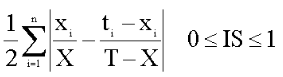

y describe la manera en la que se distribuye un grupo en el espacio en relación a otro mayor. El mismo varía entre cero y uno indicando distribuciones igualitarias o de máxima concentración. “Con este índice se calcula la diferencia entre la proporción de individuos del grupo minoritario (X) y la proporción del resto de población en cada unidad espacial. De hecho, el valor cero sólo se alcanza cuando en todas las unidades hay la misma proporción entre el grupo X y el resto de población” (Martori Cañas & Hoberg, 2004). En nuestro ejemplo, los grupos serán las viviendas según su estado de conservación. Información que utilizaremos para nuestro diagnóstico.

In [56]:
# en primer lugar creamos una función que nos ordene un gdf en función de áreas de mayor y menor nivel
def atributos_urbanos(inferior_gdf, idas, idai, universo, categoria):
    '''
    Agrupa los totales de la variable y categoría deseada a un nivel administrativo 
    superior y los mapea en el gdf de nivel administrativo inferior 
     ...
    
    Parameters:
    -----------
    inferior_gdf(gdf): area de análisis de nivel administrativo inferior
    idas(str): id del area administrativa superior
    idai(str): id del area administrativa inferior
    universo(str): nombre de la variable que contiene el universo 
                   total de nuestra categoría (e.g.: "hogares","viviendas","personas")
    categria(str): nombre de la categoría en la que se clasifica
                   nuestra variable de análisis (e.g.: "hogares con NBI","viviendas recuperables")
    
    Returns:
    -------
    dict: dataframes con totales para cada nivel administrativo
    '''
    
    # area administrativa superior
    total_universo_as = inferior_gdf.groupby(idas)[['VIVIEND']].sum()
    total_categoria_as = inferior_gdf.groupby(idas)[['recuperables']].sum()
    area_superior = total_universo_as.join(total_categoria_as)
    area_superior.columns=['variable','categoria']

    # thiner area
    area_inferior = inferior_gdf.set_index(idai).loc[:,[universo,categoria]]
    area_inferior.columns=['variable','categoria']
    
    return {'superior':area_superior, 'inferior':area_inferior}

In [89]:
# instanciamos nuestros atributos "unidades administrativas" 
unidad_administrativa = atributos_urbanos(inferior_gdf=radios_inmat, 
                                          idas='COMUNA', idai='RADIO_I', 
                                          universo='VIVIEND', categoria='recuperables')

Este va a contar con dos atributos principales. Así como un objeto pez tiene un par de aletas, o a un objeto cebra lo distinguen sus rayas (para ser lo más figurativos posibles) a nuestro objeto territorio lo va a caracterizar la presencia de un área administrativa superior y otra inferior. 

Esto se completa un poco más cuando, a partir de la incorporación de algunos métodos, logramos hacer cosas como describir a nuestro objeto no sólo por la presencia de estos atributos, sino también por la manera en la que estos se relacinoan entre sí. Probemos alguna... 

In [90]:
# Este cuenta con un unidad administrativa inferior, con totales de una variable y alguna de sus categorías.
unidad_administrativa['inferior'].head()

,variable,categoria
RADIO_I,,
1_1_1,82.0,14
1_12_1,365.0,12
1_12_10,629.0,14
1_12_11,375.0,24
1_12_2,445.0,22


In [91]:
# y nuestra unidad administrativa superior, donde agrupamos ambos valores.
unidad_administrativa['superior'].head()

,variable,categoria
COMUNA,,
1,131382.0,12009
10,71664.0,5617
11,84734.0,5930
12,93502.0,6989
13,129482.0,6651


In [92]:
class ContextoUrbano:
    
    """
    Describe un territorio a partir de la relación de atributos 
    entre áreas administrativas superiores e inferiores.
    
    Parameters
    ----------
    area_superior (pandas dataframe): households and target race totals in the coarser area  
    area_inferior (pandas dataframe): households and target race totals in the thiner area
    """
    
    # attributes
    def __init__(self, area_inferior, area_superior):
        self.area_inferior = area_inferior
        self.area_superior = area_superior
        
    # methods
    def concentracion_espacial(self, x, id_inferior, id_superior):
        # assigns the totals of the population target in the coarser area
        x['categoria_area_superior'] = x[id_superior].map(self.area_superior['categoria'])
        x['variable_area_superior'] = x[id_superior].map(self.area_superior['variable'])
        
        # assigns the totals of the population target in the thiner area
        x['categoria_area_inferior'] = x[id_inferior].map(self.area_inferior['categoria'])
        x['variable_area_inferior'] = x[id_inferior].map(self.area_inferior['variable'])
        
        # Estimates absolute for each thiner area 
        x['CEC'] = np.abs((x['categoria_area_inferior']/x['categoria_area_superior']) -\
                         ((x['variable_area_inferior'] - x['categoria_area_inferior'])/\
                         (x['variable_area_superior'] - x['categoria_area_superior'])))
        
        # Concentración espacial de la categoría
        CEC = ((x.groupby([id_superior])[['CEC']].sum()*0.5).round(3)).reset_index()
        
        return CEC
    
    def concentracion_espacial_plot(self, x, id_inferior, id_superior, estadistico, categoria, chart):
        
        if chart == 'bar':
        
            area_cec= self.concentracion_espacial(x, id_inferior, id_superior)
            area_cec['CEC_100']= round(area_cec['CEC']*100,2)

            fig, ax = plt.subplots()
            area_cec.sort_values(by=estadistico,ascending='True').plot(x=id_superior,y='CEC_100', kind='bar', 
                                                         figsize=(18,6), legend=False, ax=ax, 
                                                         title='Concentración espacial de la categoría: %s'%
                                                                       (categoria), 
                                                         color='#F5564E', edgecolor='#FAB95B', alpha=1)

            for p in ax.patches:
                ax.annotate(str(p.get_height())+'%', 
                            (p.get_x() * 1.005, p.get_height() * 1.02),
                            rotation=75)

            plt.xticks(rotation=80)
            plt.grid(axis='y', c='grey',alpha=0.1)
            plt.grid(axis='x', c='grey',alpha=0.1)
            plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
        
        if chart == 'scatter':
            area_cec= self.concentracion_espacial(x, id_inferior, id_superior)
            area_cec['CEC_100']= round(area_cec['CEC']*100,2)
            area_cec['variable'] = area_cec[id_superior].map(self.area_superior['variable'])
            area_cec['categoria'] = area_cec[id_superior].map(self.area_superior['categoria'])
            area_cec['%_categoria'] = round((area_cec['categoria']/area_cec['variable']*100),2)
            
            cec_cat = sns.lmplot(x='%_categoria', y='CEC_100', data=area_cec, aspect = 2, height=7.5, 
              line_kws={'color':'lightblue'}, scatter_kws={'color':'Red','alpha':0.4,'s': 200}, 
              fit_reg = True)

            cec_cat.fig.suptitle('Concentración del atributo VS Porcentaje por area superior', 
                                 fontsize=15, x=0.54, y=1.02)
            plt.xlabel('Porcentaje de %s por %s'%(categoria,id_superior), labelpad=20)
            plt.ylabel('Concentración espacial de la categoría: %s'%
                                 (categoria), labelpad=20)
            plt.grid(axis='y', c='grey',alpha=0.1)
            plt.grid(axis='x', c='grey',alpha=0.1)

            plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
            plt.gca().set_xticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_xticks()]) 
            
            def label_point(x, y, val, ax):
                a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
                for i, point in a.iterrows():
                    ax.text(point['x']+.02, point['y'], str(point['val']))

            label_point(area_cec['%_categoria'],area_cec['CEC_100'], area_cec.iloc[:,0], plt.gca())

            plt.tight_layout()
            
    
    def __call__(self, x, id_inferior, id_superior):
        return self.concentracion_espacial(x, id_inferior, id_superior)
    
    def __call__(self, x, id_inferior, id_superior, estadistico, categoria, chart):
        return self.concentracion_espacial_plot(x, id_inferior, id_superior, estadistico, categoria, chart)

In [93]:
# Instanciamos nuestro objeto territorio, compuesto por unidades administrativas inferiorer y superiores...
territorio = ContextoUrbano(unidad_administrativa['inferior'],unidad_administrativa['superior'])

In [94]:
# Podemos aplicar un metodo que es propio de nuestro objecto, el nivel de concenración territorial de una variable
territorio.concentracion_espacial(x=radios_inmat,id_inferior='RADIO_I',id_superior='COMUNA')

,COMUNA,CEC
0,1,0.415
1,10,0.190
2,11,0.207
3,12,0.218
4,13,0.245
5,14,0.246
6,15,0.227
7,2,0.237
8,3,0.236
9,4,0.322


In [95]:
# seteamos el color de fondo del grafico
plt.rcParams['axes.facecolor'] = 'whitesmoke'

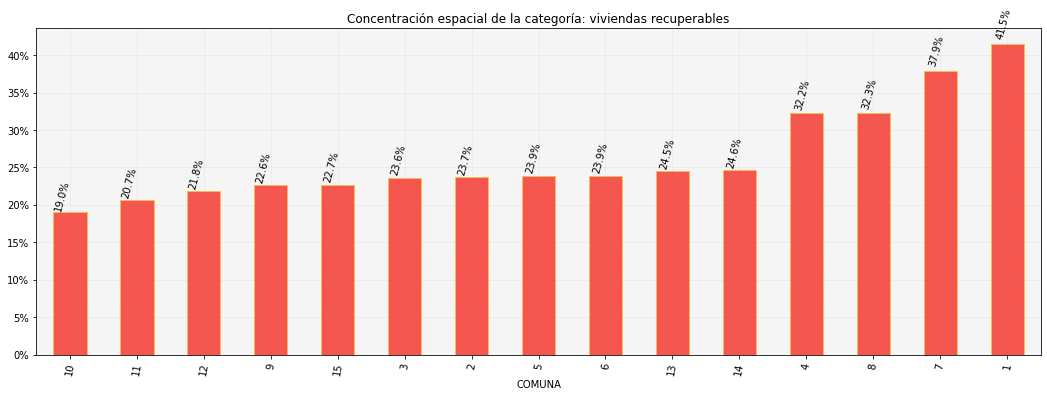

In [96]:
# o directamente pasandole los atributos que caracterizan al método dentro de nuestro objeto
territorio(x=radios_inmat,id_inferior='RADIO_I',id_superior='COMUNA', 
           estadistico='CEC', categoria='viviendas recuperables', chart = 'bar')

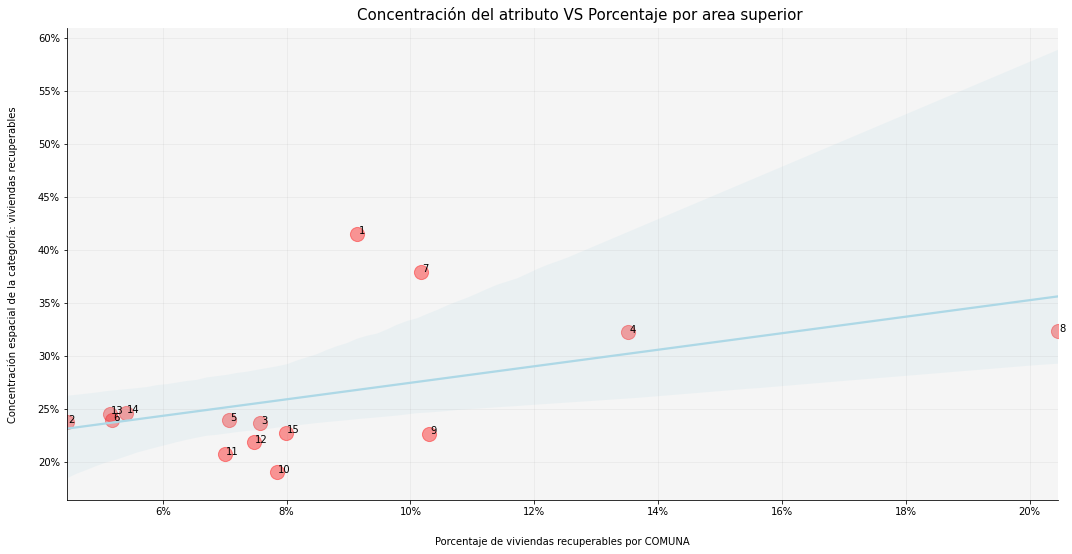

In [97]:
territorio(x=radios_inmat,id_inferior='RADIO_I',id_superior='COMUNA', 
           estadistico='CEC', categoria='viviendas recuperables', chart = 'scatter')

A su vez, esto podemos volver a integrarlo en una nueva función, lo que nos brindaría la posibilidad de alternar el área administrativa superior. Tanto para crearla como para acceder a sus métodos. Supongamos que queremos tener la ductilidad de decidir si nuetra medida de distribución territorial, es construida en relación a una u otra unidad adminisrtrativa superior. O incluso, que queremos que esta relación se apoye en atributos diferentes. Ya sea otra categoría de la variable viviendas, o por que no otra variable como hogares y la presencia de necesidades básicas insatisfechas. 

In [98]:
def construye_territorio(gdf, nombre_unidad_s, nombre_unidad_i, 
                         nombre_variable, nombre_categoria, estadistico, tipo):
    
    unidad_administrativa = atributos_urbanos(inferior_gdf=gdf, 
                                              idas = nombre_unidad_s, idai=nombre_unidad_i, 
                                              universo=nombre_variable, categoria=nombre_categoria)
    
    territorio = ContextoUrbano(unidad_administrativa['inferior'],unidad_administrativa['superior'])
    
    if estadistico:
        return territorio.concentracion_espacial_plot(x=gdf,
                                                      id_inferior=nombre_unidad_i,
                                                      id_superior=nombre_unidad_s,
                                                      estadistico=estadistico,
                                                      categoria=nombre_categoria,
                                                      chart = tipo)
    else:
        return territorio.concentracion_espacial(x=gdf,
                                                 id_inferior=nombre_unidad_i,
                                                 id_superior=nombre_unidad_s)

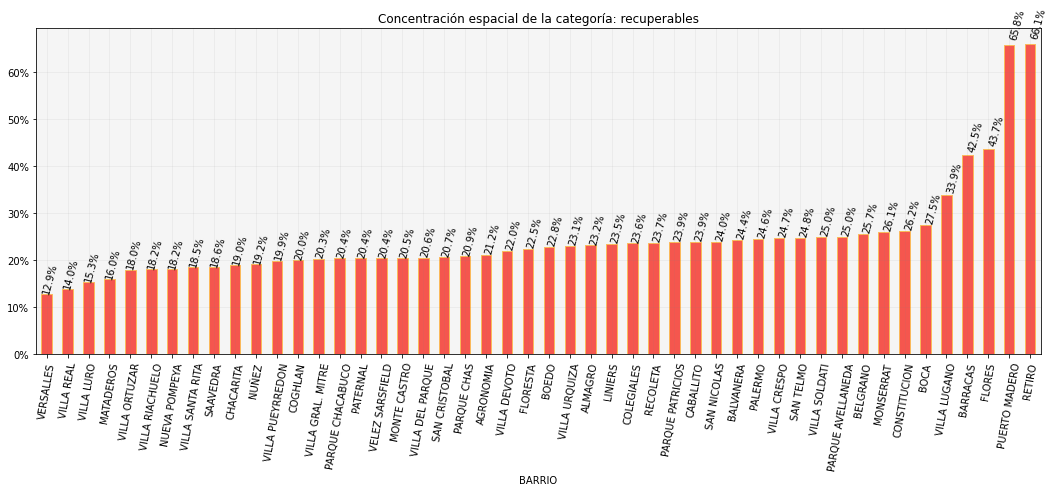

In [99]:
construye_territorio(gdf=radios_inmat, nombre_unidad_s='BARRIO', nombre_unidad_i='RADIO_I', 
                     nombre_variable='VIVIEND', nombre_categoria='recuperables', estadistico='CEC', tipo='bar')

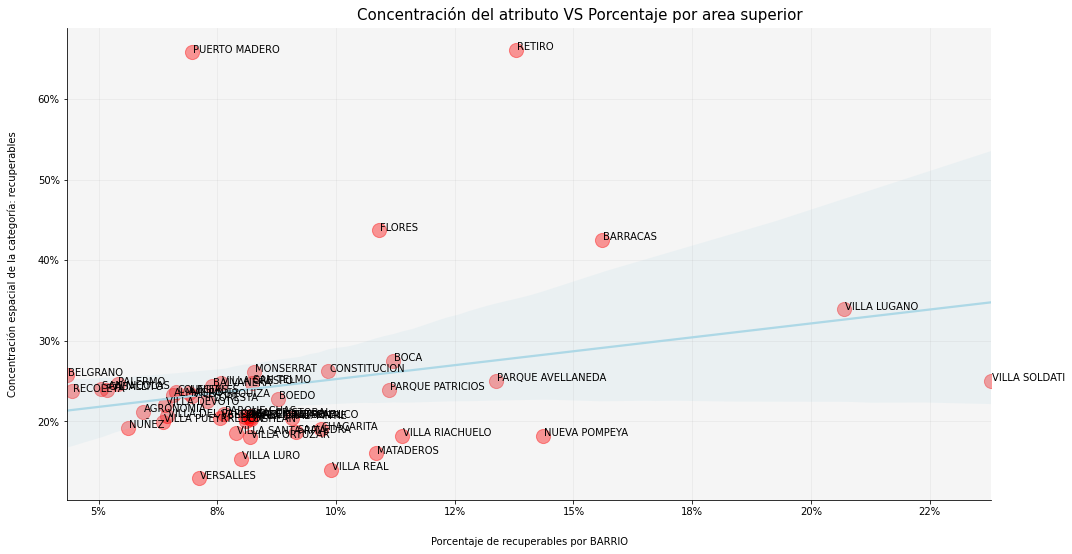

In [100]:
construye_territorio(gdf=radios_inmat, nombre_unidad_s='BARRIO', nombre_unidad_i='RADIO_I', 
                     nombre_variable='VIVIEND', nombre_categoria='recuperables', estadistico='CEC', tipo='scatter')

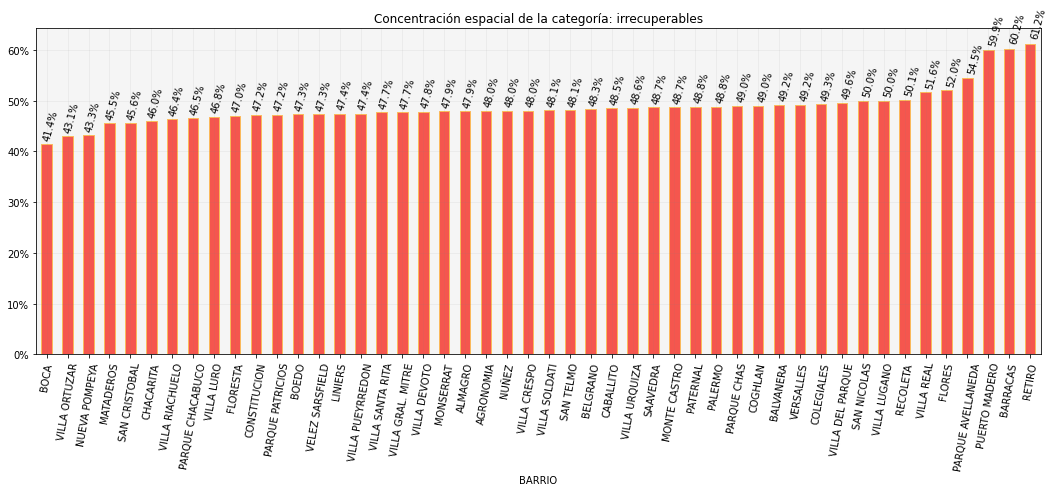

In [101]:
construye_territorio(gdf=radios_inmat, nombre_unidad_s='BARRIO', nombre_unidad_i='RADIO_I', 
                     nombre_variable='VIVIEND', nombre_categoria='irrecuperables', estadistico='CEC', tipo='bar')

Acá no solamente sería posible alternar entre áreas administrativas superiores de distintos niveles. Tomando siempre como unidad mínima el radio censal, podríamos ir agregando otras variables (para lo que deberíamos volver a unir un atributo deseado como hicimos al principio del notebook). Podrían ser hogares con NBI o algún otro atributo de las viviendas como calidad de conexión a servicios básicas y reniciar todo el proceso. Como ejercicio, les proponemos que visiten el Web redatam, descarguen alguna información de interés e intenten aplicar esta clase pero tratando de entender la distribución territorial de algún atrbuto que sea de su interés. También pueden construir su propia métrica.

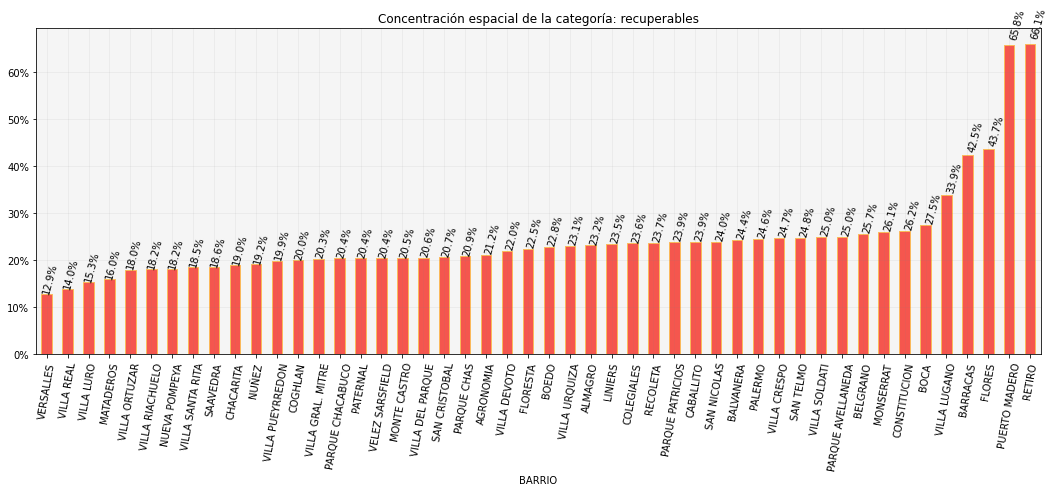

In [102]:
construye_territorio(gdf=radios_inmat, nombre_unidad_s='BARRIO', nombre_unidad_i='RADIO_I', 
                     nombre_variable='VIVIEND', nombre_categoria='recuperables', estadistico='CEC', tipo='bar')

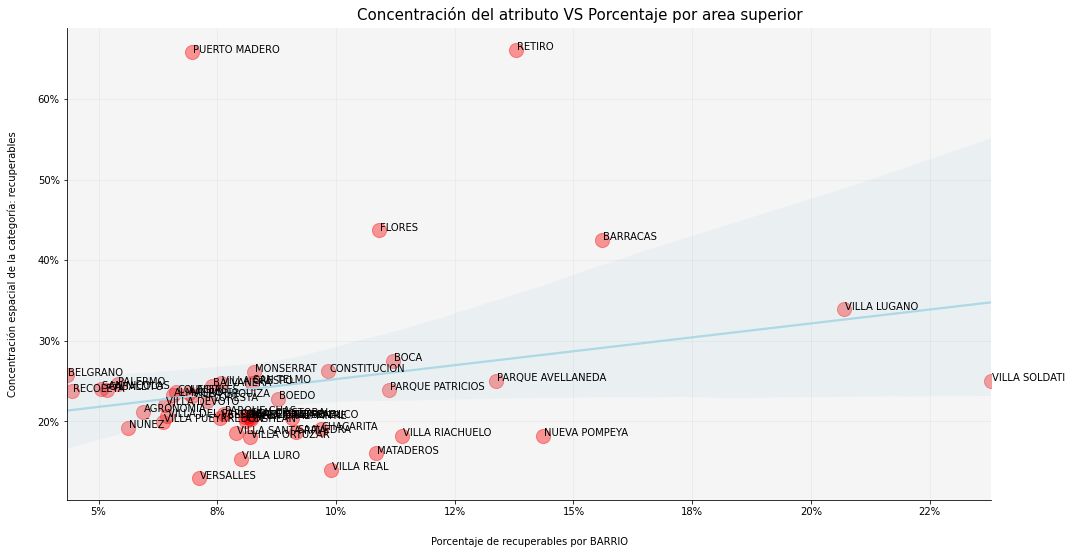

In [103]:
construye_territorio(gdf=radios_inmat, nombre_unidad_s='BARRIO', nombre_unidad_i='RADIO_I', 
                     nombre_variable='VIVIEND', nombre_categoria='recuperables', estadistico='CEC', tipo='scatter')

Para concluir, tratemos de darle una interpretación a esto que construimos. Para eso, sería muy útil poder ver cómo se comporta espacialmente este índice que definimos a partir de la interrelación de dos de los atributos de nuestro objeto `territorio`. Por lo que pudimos ver, los valores más altos se ubicaban hacie el borde este (Puerto Madelo y Retiro) y hacia la zona sur (Barracas, La Boca, Lugano, etc.).

Tratemos entonces de llevar el scatter que inlcuimos como método en nuestra clase, a un mapa que combine tanto el nivel administrativo inferior como superior. 

In [104]:
# cargamos el gdf de comunas
comunas = gpd.read_file('carto/comunas.shp')

In [105]:
comunas.head()

,BARRIOS,PERIMETRO,AREA,COMUNAS,ID,OBJETO,geometry
0,RECOLETA,21452.838648,6.317265e+06,2.0,1,LIMITE COMUNAL,"POLYGON ((107643.458 106569.299, 107641.492 10..."
1,ALMAGRO - BOEDO,12323.432479,6.660603e+06,5.0,2,LIMITE COMUNAL,"POLYGON ((104625.143 101679.935, 104629.994 10..."
2,CABALLITO,10990.964471,6.851029e+06,6.0,3,LIMITE COMUNAL,"POLYGON ((102998.760 102464.802, 103002.947 10..."
3,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,7.0,4,LIMITE COMUNAL,"POLYGON ((101036.604 99947.208, 101075.002 998..."
4,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,9.0,5,LIMITE COMUNAL,"POLYGON ((94869.346 99583.645, 94885.072 99583..."


In [106]:
cec = territorio.concentracion_espacial(x=radios_inmat,id_inferior='RADIO_I',id_superior='COMUNA')

In [107]:
# creamos esta funcion para asegurarnos que los dtypes de las columnas con las que uniremos sean iguales
def cambia_tipo(df,columna):
    df[columna]=df[columna].apply(lambda x: int(x))
    return df

In [108]:
# mergeamos nuestro indice de concentracion
comunas = pd.merge(cambia_tipo(comunas, 'COMUNAS'), cambia_tipo(cec, 'COMUNA'), 
                   how='left',left_on='COMUNAS', right_on='COMUNA')

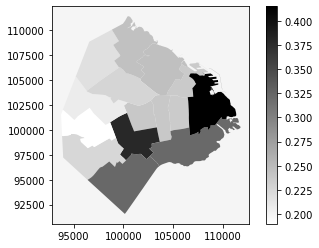

In [109]:
comunas.plot(column='CEC', cmap = 'gist_yarg', legend=True);

In [110]:
# creamos la variable a constrastar, en este caso el porcentaje de viviendas recuperables por radio censal
radios_inmat['z_recuperables'] = round(radios_inmat['recuperables']/radios_inmat['VIVIEND']*100,2)

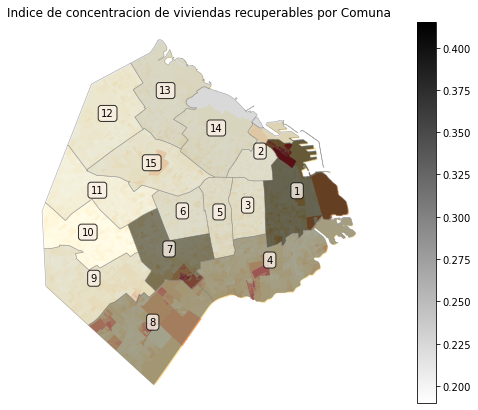

In [111]:
# y ploteamos...
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(1,1,1)

radios_inmat.to_crs(comunas.crs).plot(column = 'z_recuperables',cmap='YlOrRd',ax=ax1, alpha = 0.9, legend=False)
comunas.plot(ax=ax1, column='CEC', cmap = 'gist_yarg',edgecolor='grey', 
             linewidth=0.6, alpha = 0.6, legend=True)

props = dict(boxstyle='round', facecolor='linen', alpha=0.8)
for point in comunas.iterrows():
    ax1.text(point[1]['geometry'].centroid.x,
             point[1]['geometry'].centroid.y,
             point[1]['COMUNAS'],
             horizontalalignment='center',
             fontsize=10,
             bbox=props) 

ax1.set_axis_off()
ax1.set_title('Indice de concentracion de viviendas recuperables por Comuna');

Ejercicio: 

1. Instanciar un objeto territorio donde el nivel administrativo superior sean los barrios.
2. Elegir una variable (puede ser la misma, viviendas recuperables) y calcular su porcentaje sobre el total para la unidad amidnistrativainferior.
3. Agregar el GDF de nivel superior el valor del índice de concentración.
4. Plotear ambos GDF superponiendo el índice en la capa superior.
5. A los que hayan elegido la misma capa (viviendas recuperables), agregarla al `ax2` del plot anterior.